In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/Notebooks/libs')

In [8]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm
import time
import cv2
from DataCaller import DataCaller
from EarlyStopper import *
from Net import *
from train_test import *
from utils import *

#use gpu    please somebody buy me a gpu .......
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

#Global variables
LOAD_DATA = False
BATCH_SIZE = 36
VAL_BATCH_SIZE = 16
LEARNING_RATE = 4e-4
EPOCHS = 30
PATIENCE = 10
VALIDATE_EVERY = 10
MODEL_NAME = f"model-{int(time.time())}"
IMG_SIZE = 64
IMG_CHANNELS = 4
TRAIN_LABEL_SIZE = 6
TEST_LABEL_SIZE = 3
OUTPUT_SIZE = 3
weight = torch.tensor([100.0, 100.0, 10.0, 100.0])
limit = 100

BASE_PATH = '/content/gdrive/My Drive/Colab Notebooks/Reverse_Method_Horn/data'
TRAIN_DATA_PATH = os.path.join(BASE_PATH, 'test_gen/train')
VAL_DATA_PATH = os.path.join(BASE_PATH, 'test_gen/val')
TEST_DATA_PATH = os.path.join(BASE_PATH, 'test_gen/test')


cuda


In [0]:

if LOAD_DATA:
    trainsets = []
    valsets = []
    testsets = []
    for f in tqdm(os.listdir(TRAIN_DATA_PATH)):
      path = os.path.join(TRAIN_DATA_PATH, f)
      trainset = DataCaller(path, IMG_SIZE, TRAIN_LABEL_SIZE)
      print(trainset.__len__())
      trainsets.append(trainset)

    for f in tqdm(os.listdir(VAL_DATA_PATH)):
      path  = os.path.join(VAL_DATA_PATH, f)
      valset = DataCaller(path, IMG_SIZE, TRAIN_LABEL_SIZE)
      print(valset.__len__())
      valsets.append(valset)

    for f in tqdm(os.listdir(TEST_DATA_PATH)):
      path  = os.path.join(TEST_DATA_PATH, f)
      testset = DataCaller(path, IMG_SIZE, TEST_LABEL_SIZE)
      print(testset.__len__())
      testsets.append(testset)

    trainset = ConcatDataset(trainsets)
    print(trainset.__len__())
    valset = ConcatDataset(valsets)
    print(valset.__len__())
    testset = ConcatDataset(testsets)
    print(testset.__len__())  

In [0]:
  #define dataloaders
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)
valloader = DataLoader(valset, batch_size=VAL_BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=1, shuffle=False)

In [11]:
cnt = 0
for i, data in enumerate(trainloader):
    x, y = data
    filter_input(x)
    x = np.array(x)
    x = x.reshape(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)

    print(x[0])
    print(x[0].shape)

    print(y[0])
    cnt += 1
    if cnt==1:
      break

[[[22.563   22.419   21.979   ...  0.67805  0.44555  0.22026]
  [22.563   22.418   21.976   ...  0.       0.       0.     ]
  [22.563   22.415   21.965   ...  0.       0.       0.     ]
  ...
  [22.563   22.415   21.964   ...  0.       0.       0.     ]
  [22.563   22.418   21.976   ...  0.       0.       0.     ]
  [22.563   22.419   21.979   ...  0.67805  0.44555  0.22026]]

 [[22.545   22.488   22.14    ...  0.79643  0.57109  0.34802]
  [22.545   22.487   22.135   ...  0.       0.       0.     ]
  [22.545   22.483   22.121   ...  0.       0.       0.     ]
  ...
  [22.545   22.482   22.121   ...  0.       0.       0.     ]
  [22.545   22.487   22.135   ...  0.       0.       0.     ]
  [22.545   22.488   22.14    ...  0.79643  0.57109  0.34802]]

 [[22.499   22.53    22.272   ...  0.85461  0.63638  0.41551]
  [22.499   22.528   22.266   ...  0.       0.       0.     ]
  [22.499   22.523   22.25    ...  0.       0.       0.     ]
  ...
  [22.499   22.523   22.249   ...  0.       0.  

In [12]:
net = Net(IMG_CHANNELS, OUTPUT_SIZE)
net.to(device)
train_losses, valid_losses = train(net, trainloader, valloader, weight, EPOCHS, LEARNING_RATE, IMG_CHANNELS, IMG_SIZE, MODEL_NAME, PATIENCE, VALIDATE_EVERY, device)

  0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([36, 1])) that is different to the input size (torch.Size([36])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28, 1])) that is different to the input size (torch.Size([28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the sa


loss :  8056.404459635417 val loss :  7261.2213134765625 

Validation loss decreased (inf --> 7261.221313).  Saving model ...

loss :  7872.519368489583 val loss :  6835.2381591796875 

Validation loss decreased (7261.221313 --> 6835.238159).  Saving model ...

loss :  7497.831380208333 val loss :  6538.2740478515625 

Validation loss decreased (6835.238159 --> 6538.274048).  Saving model ...


 20%|██        | 6/30 [00:00<00:01, 13.25it/s]


loss :  6615.1044921875 val loss :  5774.7447509765625 

Validation loss decreased (6538.274048 --> 5774.744751).  Saving model ...

loss :  4829.901529947917 val loss :  3513.514404296875 

Validation loss decreased (5774.744751 --> 3513.514404).  Saving model ...

loss :  2022.5228678385417 val loss :  912.22021484375 

Validation loss decreased (3513.514404 --> 912.220215).  Saving model ...


 27%|██▋       | 8/30 [00:00<00:01, 13.14it/s]


loss :  1449.5518595377605 val loss :  611.8825149536133 

Validation loss decreased (912.220215 --> 611.882515).  Saving model ...

loss :  1434.8665161132812 val loss :  914.5483093261719 

EarlyStopping counter: 1 out of 10

loss :  832.0562540690104 val loss :  1906.2820434570312 

EarlyStopping counter: 2 out of 10


 40%|████      | 12/30 [00:00<00:01, 13.38it/s]


loss :  1243.538106282552 val loss :  1949.3826293945312 

EarlyStopping counter: 3 out of 10

loss :  1103.1748453776042 val loss :  1364.0049743652344 

EarlyStopping counter: 4 out of 10

loss :  768.2143351236979 val loss :  842.9066162109375 

EarlyStopping counter: 5 out of 10


 47%|████▋     | 14/30 [00:01<00:01, 13.24it/s]


loss :  844.6954752604166 val loss :  639.4461441040039 

EarlyStopping counter: 6 out of 10

loss :  873.2919921875 val loss :  912.0548553466797 

EarlyStopping counter: 7 out of 10

loss :  699.9224446614584 val loss :  1091.5634307861328 

EarlyStopping counter: 8 out of 10


 53%|█████▎    | 16/30 [00:01<00:01, 12.51it/s]


loss :  774.7301432291666 val loss :  1178.2581176757812 

EarlyStopping counter: 9 out of 10

loss :  753.3498331705729 val loss :  1265.0342559814453 

EarlyStopping counter: 10 out of 10
Early stopping


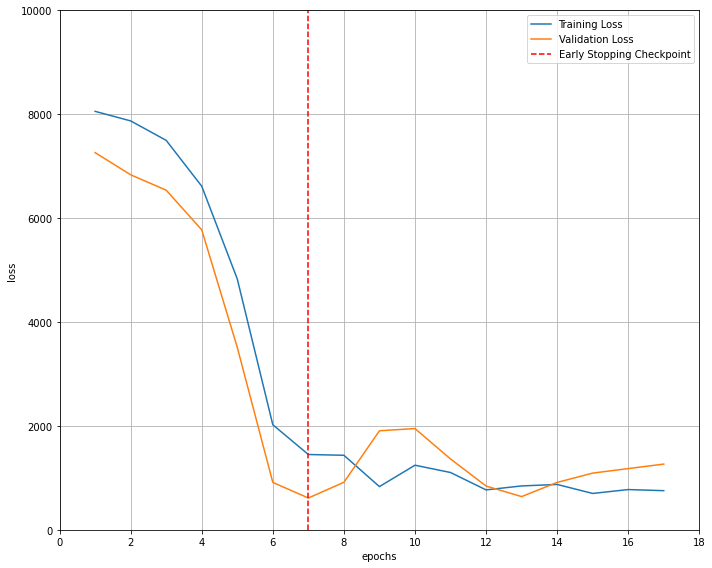

In [17]:
save_plot(train_losses, valid_losses, 10000)

In [15]:

test(net, testloader, IMG_CHANNELS, IMG_SIZE, OUTPUT_SIZE, device)

[array([[4.820979 , 4.7731247, 1.3569429]], dtype=float32), array([[4.9137073, 4.8488717, 1.3812876]], dtype=float32), array([[5.9861465, 5.760828 , 1.7117712]], dtype=float32), array([[4.8129315, 4.7687564, 1.3551431]], dtype=float32), array([[4.8416867, 4.7809153, 1.3605589]], dtype=float32), array([[4.648138 , 4.6013184, 1.3070184]], dtype=float32), array([[4.8908095, 4.8039813, 1.3792309]], dtype=float32), array([[5.4677844, 5.3726654, 1.540696 ]], dtype=float32), array([[5.119803 , 5.0213995, 1.4492527]], dtype=float32), array([[4.6173096, 4.565555 , 1.3001115]], dtype=float32), array([[4.805985 , 4.7569594, 1.352176 ]], dtype=float32), array([[5.906939 , 5.7349477, 1.6914477]], dtype=float32), array([[5.001604, 4.949309, 1.412242]], dtype=float32), array([[5.179108 , 5.077294 , 1.4641414]], dtype=float32), array([[5.3114786, 5.159132 , 1.5070415]], dtype=float32), array([[5.598337 , 5.422935 , 1.5973525]], dtype=float32), array([[5.640694 , 5.461908 , 1.6082194]], dtype=float32),

In [0]:
net = Net(IMG_CHANNELS, OUTPUT_AB, OUTPUT_DT)
net.load_state_dict(torch.load('/content/gdrive/My Drive/Colab Notebooks/Reverse_Dipole_Array/results/data2/trial2/checkpoint.pt'))
net.to(device)

BASE_PATH = '/content/gdrive/My Drive/Colab Notebooks/Reverse_Dipole_Array/data'
TEST_DATA_PATH = os.path.join(BASE_PATH, 'data2/test1')
testsets = []
for f in tqdm(os.listdir(TEST_DATA_PATH)):
  path  = os.path.join(TEST_DATA_PATH, f)
  testset = DataCaller(path, IMG_SIZE, 3)
  print(testset.__len__())
  testsets.append(testset)

testset = ConcatDataset(testsets)
testloader = DataLoader(testset, batch_size=1, shuffle=False)

test(net, testloader, IMG_CHANNELS, IMG_SIZE, LABEL_SIZE, device)

100%|██████████| 1/1 [00:03<00:00,  3.66s/it]

200


[array([[10.733622 , 11.981575 ,  4.56017  ,  0.2079498]], dtype=float32), array([[ 9.584008  , 11.263124  ,  3.6433337 ,  0.38214955]],
      dtype=float32), array([[10.376097 , 10.613118 ,  3.7550483,  0.4009773]], dtype=float32), array([[7.877797  , 9.092867  , 2.548987  , 0.86399835]], dtype=float32), array([[11.380598  , 12.261465  ,  4.277638  ,  0.29542965]],
      dtype=float32), array([[ 8.878759  , 10.146637  ,  4.949039  ,  0.37282926]],
      dtype=float32), array([[10.648582  , 10.191018  ,  2.7920418 ,  0.83383405]],
      dtype=float32), array([[12.041682 , 13.300427 ,  3.5722492,  0.5601551]], dtype=float32), array([[ 9.537392  , 10.691327  ,  3.7473226 ,  0.52842295]],
      dtype=float32), array([[11.051412  , 10.804475  ,  3.828372  ,  0.58773386]],
      dtype=float32), array([[10.948825  , 11.553807  ,  4.133604  ,  0.40017325]],
      dtype=float32), array([[10.856114  , 12.306865  ,  4.4512033 ,  0.17055325]],
      dtype=float32), array([[10.936904 , 11.713504 ,